In [42]:
from sklearn.model_selection import train_test_split

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse


# Carregando e preparando os dados para os modelos de regressão linear

In [2]:
df_train = pd.read_csv('../../input/clean_data/renner_web_treino.csv')
df_test = pd.read_csv('../../input/renner_desafio_pucrs_teste_1.csv')

In [9]:
df_train.head()

,cod_loja,data_semana_comercial,venda
0,407,2022-06-05,188
1,407,2021-05-23,136
2,406,2021-05-30,926
3,407,2022-04-03,152
4,407,2022-07-24,33


In [10]:
df_test, _ = dataPipeline(df_test)

Dataframe carregado!
Colunas 'item' e 'semana_comercial' dropadas!
Vendas Guide Shop (GS) dropadas!
Vendas negativas alteradas para zero!
Variaveis categoricas transformadas em numéricas!
coluna 'data_semana_comercial' transformada em datetime!
Dataset de treino para lojas web criado
Dataset de treino para lojas fisicas criado


In [11]:
df_test.head()

,cod_loja,data_semana_comercial,venda
1,407,2022-06-05,188
62,406,2022-05-15,1269
185,407,2022-06-12,129
707,406,2022-05-08,605
766,406,2022-05-29,737


In [14]:
df_train.shape

(406, 3)

In [13]:
df_test.shape

(16, 3)

In [19]:
del df_train['cod_loja']

In [22]:
df_train = df_train.set_index('data_semana_comercial')
df_train.index = pd.to_datetime(df_train.index)

<AxesSubplot: title={'center': 'Vendas lojas web'}, xlabel='data_semana_comercial'>

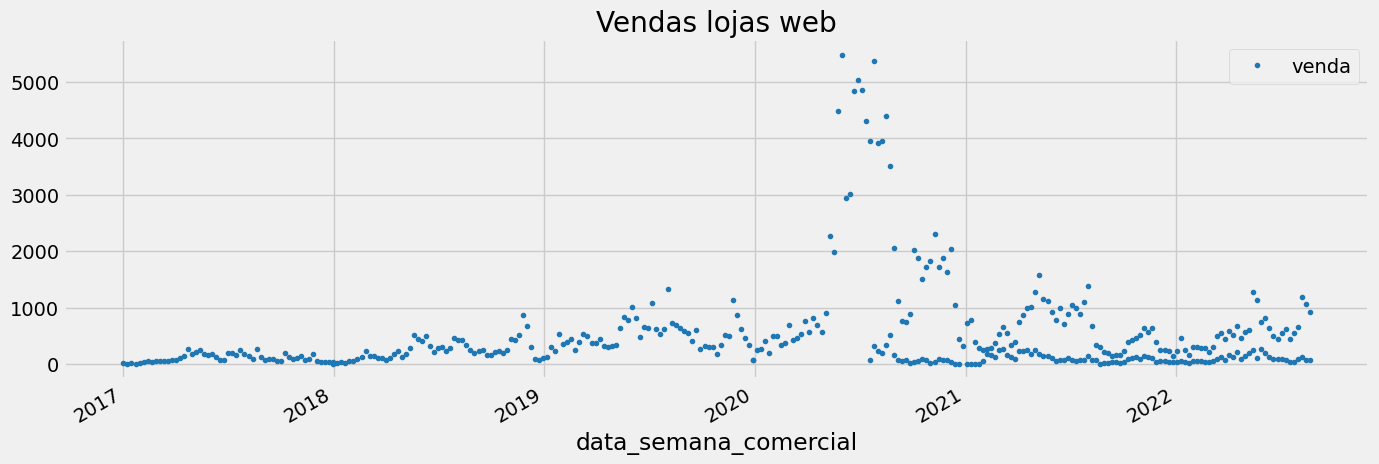

In [23]:
df_train.plot(style='.',
              figsize=(15,5),
              color=color_pal[0],
              title='Vendas lojas web')

<AxesSubplot: ylabel='Frequency'>

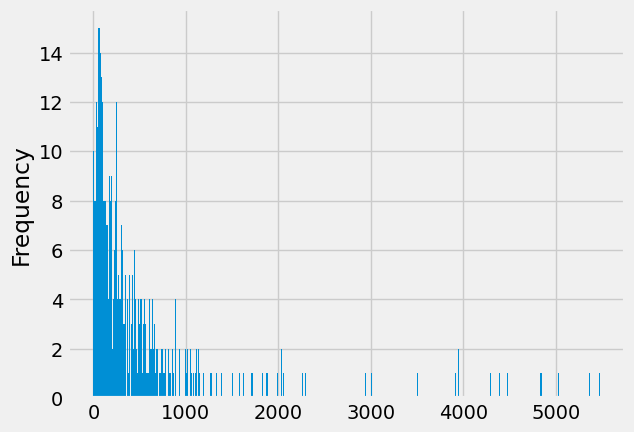

In [24]:
df_train['venda'].plot(kind='hist', bins=500)

In [33]:
df = df_train.query('venda < 2000').copy()

<AxesSubplot: title={'center': 'Vendas lojas web'}, xlabel='data_semana_comercial'>

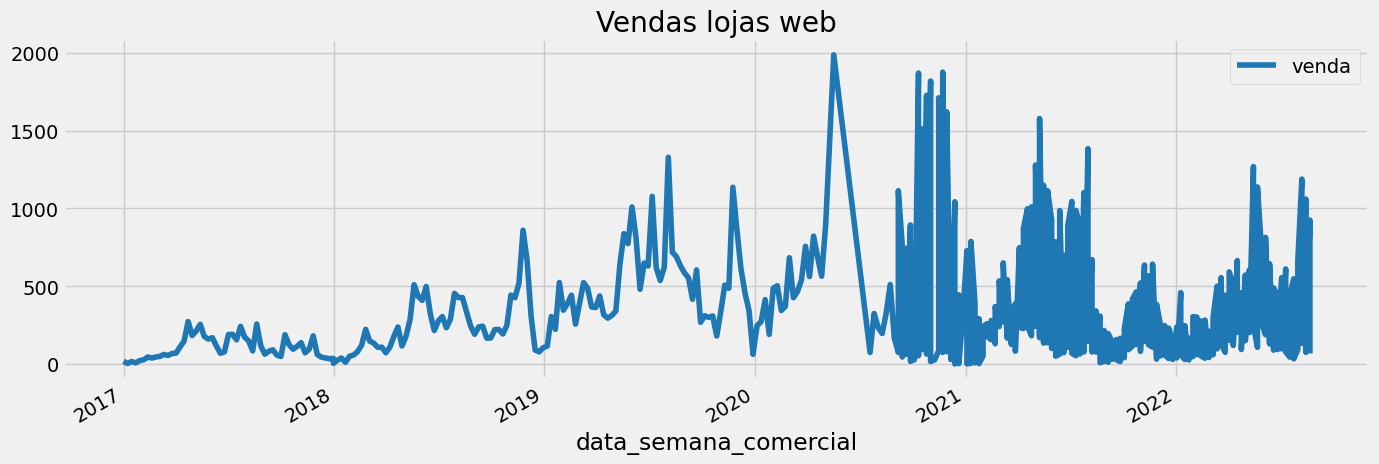

In [40]:
df.plot(
              figsize=(15,5),
              color=color_pal[0],
              title='Vendas lojas web')

# XGBoost

Time Series cross validation

In [47]:
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()


In [49]:
df.index.min(), df.index.max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2022-08-21 00:00:00'))

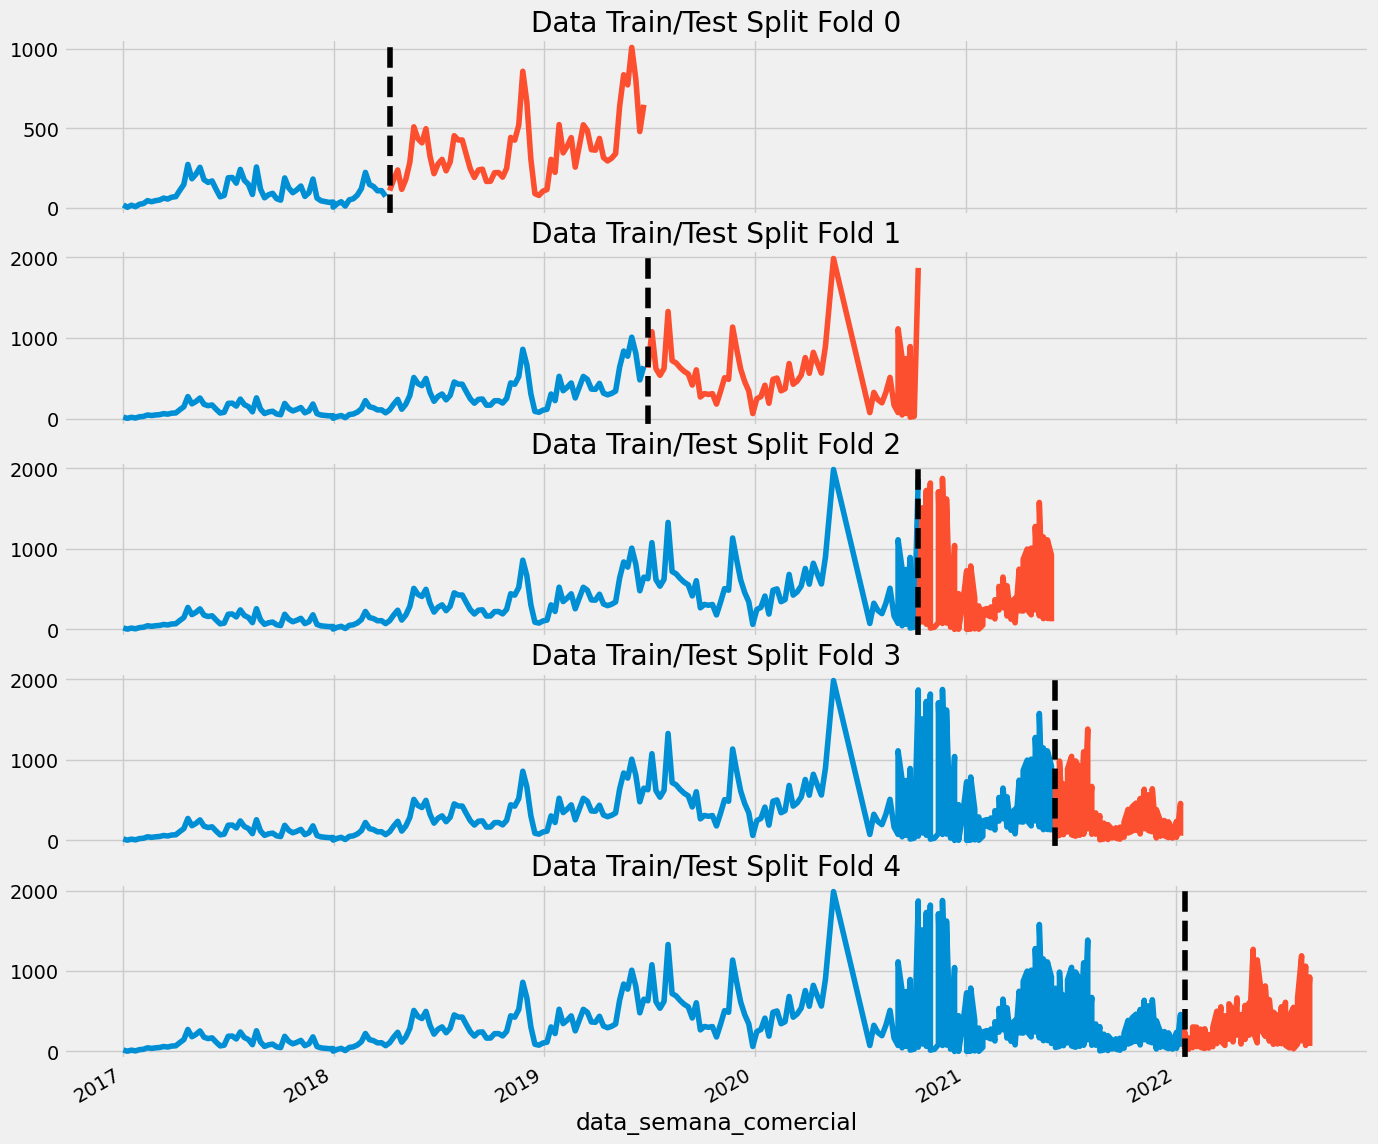

In [48]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['venda'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['venda'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Forecastin Horizon 

In [50]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

### lag Features

In [60]:
def add_lags(df):
    target_map = df['venda'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    
    return df

In [61]:
df = add_lags(df)

In [6]:
def dataPipeline(dataframe):
    """
        Args:
            dataframe: Pandas dataframe com os dados de vendas
        Return:
            df_web: dataframe com os dados necessários para previsão das lojas web
            df_fisica: dataframe com os dados necessários para previsão das lojas fisicas
        OBS:
            Para previsão de séries temporais, após chamar o metodo e receber os novos dataframes, é preciso transformar
            a coluna 'data_semana_comercial' em datetime novamente e coloca-lá como index do df.
        OBS2:
            Se precisar usar os dias da semana, mes ou ano, basta usar os atributos do index após transformá-lo
    """
    df_pipe = dataframe.copy()
    print('Dataframe carregado!')

    #Dropando colunas desnecessárias
    df_pipe.drop(['item', 'semana_comercial'], axis=1, inplace=True)
    print("Colunas 'item' e 'semana_comercial' dropadas!")

    #Dropando linhas com vendas Guide Shop ('GS')
    df_pipe = df_pipe.loc[df_pipe['clima'] != 'GS']
    print('Vendas Guide Shop (GS) dropadas!')

    #Alterando vendas negativas para zero
    df_pipe.loc[df_pipe.venda < 0, 'venda'] = 0
    print('Vendas negativas alteradas para zero!')

    #Transformando variaveis categóricas em variaveis numéricas
    df_pipe['localidade'] = df_pipe['localidade'].map({ 'br':2, 'uy':1, 'ar':0 })
    df_pipe['loja_tamanho'] = df_pipe['loja_tamanho'].map({ 'PP':0, 'P':1, 'M':2, 'G':3, 'GG':4 })
    df_pipe['clima'] = df_pipe['clima'].map({ 'SPO':5, 'RIO':4, 'NOR':3, 'SUL':2 ,'URU':1 ,'ARG': 0, 'W':'W'})
    print('Variaveis categoricas transformadas em numéricas!')

    #Transformando a coluna 'data_semana_comercial' em datetime
    df_pipe.data_semana_comercial = pd.to_datetime(df_pipe.data_semana_comercial)
    print("coluna 'data_semana_comercial' transformada em datetime!")

    #Tratando dataset para lojas web
    df_web = df_pipe[df_pipe['categoria_loja'] == 'web']
    del df_web['categoria_loja']
    del df_web['clima']
    del df_web['localidade']
    del df_web['loja_tamanho']
    print('Dataset de treino para lojas web criado')
    

    #Tratando dataset para lojas web
    df_fisica = df_pipe[df_pipe['categoria_loja'] == 'fisica']
    del df_fisica['categoria_loja']
    print('Dataset de treino para lojas fisicas criado')
    
    return df_web, df_fisica